# Predicting most Efficient Interventions for Life Span Increase
#### Data Literacy at University of Tübingen, Winter 2023/24

---
&copy; Daniel Flat, Jackson Harmon, Eric Nazarenus, Aline Bittler 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

Template by Philipp Hennig, 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error
from scipy.integrate import quad

from dataclasses import dataclass

from math import sqrt

In [2]:
# Constants for columns
DEATH_COLUMN = 'dead'
RUNNING_MORALITY_PERCENTAGE_COLUMN = 'cumulative deaths %'
PROBABILITY_OF_DEATH_PER_PERIOD_COLUMN = 'p(death per time period)'
AGE_IN_DAYS_COLUMN = 'age(days)'

# Human dataset columns
HUMAN_AGE_IN_YEARS_COLUMN = 'Age'
HUMAN_DEATHS_PER_YEAR_COLUMN = 'Total'

# Constants for column values
CONTROL_GROUP_KEY = 'Control'

# time periods to bin mice by
# 13 was chosen because it is the fixed
# time period that made the data closest to having
# sqrt(dataset size) bins
mouse_bin_period_in_days = 13

days_per_years = 365

In [3]:
df = pd.read_csv(
    "Lifespans_ITP1.csv",
    skiprows=0,
    sep=";",
    index_col=[0, 1],
    skipfooter=0,
    engine="python",
    decimal=",",
)
df

site sex       id     group Rx(ppm) age_initiation(mo)  \
population cohort                                                          
UM-HET3    C2004   TJL   m  JL00005  4-OH-PBN     315                4.0   
           C2004   TJL   m  JL00006  4-OH-PBN     315                4.0   
           C2004   TJL   m  JL00007  4-OH-PBN     315                4.0   
           C2004   TJL   f  JL00095  4-OH-PBN     315                4.0   
           C2004   TJL   f  JL00096  4-OH-PBN     315                4.0   
...                ...  ..      ...       ...     ...                ...   
           C2017    UT   m  UT10744       Syr     300                5.0   
           C2017    UT   m  UT10745       Syr     300                5.0   
           C2017    UT   m  UT10783       Syr     300                5.0   
           C2017    UT   m  UT10784       Syr     300                5.0   
           C2017    UT   m  UT10785       Syr     300                5.0   

                  status  dead  age(days)  
population cohort                          
UM-HET3    C2004    dead     1        896  
           C2004    dead     1       1077  
           C2004    dead     1        790  
           C2004    dead     1        823  
           C2004    dead     1        601  
...                  ...   ...        ...  
           C2017    dead     1        289  
           C2017    dead     1        662  
           C2017    dead     1        440  
           C2017    dead     1        342  
           C2017    dead     1        754  

[27574 rows x 9 columns]

In [4]:
control_group = df.loc[df['group'] == CONTROL_GROUP_KEY]
control_group = control_group.sort_values(by=[AGE_IN_DAYS_COLUMN])
control_group

site sex       id    group Rx(ppm) age_initiation(mo)  \
population cohort                                                         
UM-HET3    C2005    UT   f  UT01531  Control       0                NaN   
           C2004    UT   m  UT00803  Control       0                NaN   
           C2005    UT   f  UT01532  Control       0                NaN   
           C2005    UT   f  UT01529  Control       0                NaN   
           C2005    UT   f  UT01530  Control       0                NaN   
...                ...  ..      ...      ...     ...                ...   
           C2007   TJL   f  JL03117  Control     0.0                NaN   
           C2014   TJL   f  JL11157  Control     0.0                NaN   
           C2007    UM   f  UM23597  Control     0.0                NaN   
           C2015   TJL   f  JL12242  Control       0                NaN   
           C2011    UM   f  UM38745  Control       0                NaN   

                    status  dead  age(days)  
population cohort                            
UM-HET3    C2005   removed     0         27  
           C2004      dead     1         27  
           C2005   removed     0         27  
           C2005   removed     0         29  
           C2005   removed     0         29  
...                    ...   ...        ...  
           C2007      dead     1       1340  
           C2014      dead     1       1358  
           C2007      dead     1       1359  
           C2015      dead     1       1396  
           C2011      dead     1       1456  

[7815 rows x 9 columns]

# Mouse Dataset Preprocessing (Bucketing)
Here we bucket (or group) deaths in the mouse dataset into a bucket of a certain fixed time range (e.g. death in 0-9 days, 10-19 days, 20-29 days, etc.). We do this as the deaths are currently recorded as they occur which can occur at any length of time, thereby making the data less easily intepretable and less compatable with most human dataset

In [5]:
def group_same_ages(data) -> pd.DataFrame:
    return data.groupby(AGE_IN_DAYS_COLUMN).sum()

def group_ages(data: pd.DataFrame, bin_period_in_days: int) -> pd.DataFrame:
    data = data[[DEATH_COLUMN, AGE_IN_DAYS_COLUMN]]

    data = group_same_ages(data)
    
    group_days_by_time_period = lambda x: (x // bin_period_in_days)
    groupped_data_by_time_period = data.groupby(group_days_by_time_period).sum()

    index_name = f'age(per {bin_period_in_days} days)'
    groupped_data_by_time_period.index.name = index_name
    return groupped_data_by_time_period

dead_counts = group_ages(control_group, mouse_bin_period_in_days)
dead_counts

,dead
age(per 13 days),
2,1
3,2
4,1
5,0
6,2
...,...
102,2
103,2
104,2


# Mouse Dataset Preprocessing (Mortality Rate per Time Period)

We follow this with computing the chance of death with a time period range. As an example, if there were 1,000 mice alive at *day 100* and 900 left at 110 days (with 10 being the bucket size of the histogram), then (1,000 - 900) / 1,000 = 10% would be the calculated chance of death. This ignores how many mice were alive initially at the start of the experiment for that particular calculation.

In [6]:
def calculate_running_alive_counts(data: pd.DataFrame) -> pd.DataFrame:
    total = calculate_total(data)
    running_alive = total - data.cumsum()

    # Start dataset with all alive and drop the last column to maintain same
    # shape as before
    running_alive.index += 1
    running_alive = pd.concat([pd.DataFrame([total]), running_alive])[:-1]

    return running_alive

def calculate_total(data: pd.DataFrame) -> pd.DataFrame:
    return data.sum()

def compute_chance_of_death_per_time_period(dead_counts: pd.DataFrame,
                                            running_alive_counts: pd.DataFrame) -> pd.DataFrame:
    return dead_counts / (running_alive_counts + 1e-9)

running_alive_counts = calculate_running_alive_counts(dead_counts)
chance_of_death_per_time_period = compute_chance_of_death_per_time_period(dead_counts, running_alive_counts)

chance_of_death_per_time_period

,dead
0,NaN
2,NaN
3,0.000272
4,0.000136
5,0.000000
...,...
104,0.500000
105,NaN
107,NaN
108,NaN


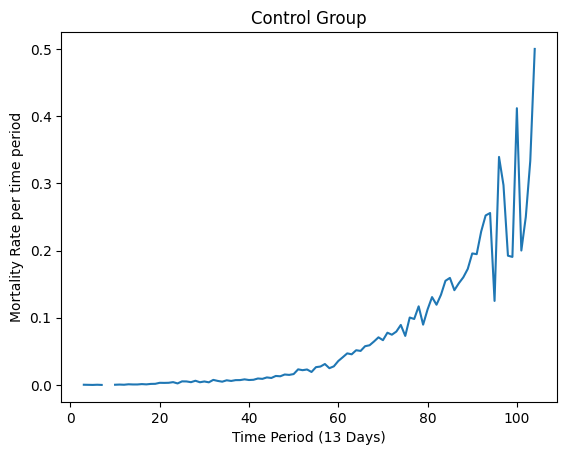

In [7]:
def graph_chance_of_death_per_time_period(chance_of_death_per_time_period: pd.DataFrame,
                                          time_period_in_days: int,
                                          title: str) -> None: 
    plt.plot(chance_of_death_per_time_period)
    plt.xlabel(f'Time Period ({time_period_in_days} Days)')
    plt.ylabel(f'Mortality Rate per time period')
    plt.title(title)
    plt.show()

graph_chance_of_death_per_time_period(chance_of_death_per_time_period, mouse_bin_period_in_days, 'Control Group')

# Mouse Dataset Preprocessing (Cumulative Mortality Rate)

In contrast with the mortality rate per time period, here we consider the morality rate with respect to the initial population size. As an example, if there were 1,000 mice alive at *the start of the experiment* and 900 left at 110 days, then (1,000 - 900) / 1,000 = 10% would be the calculated chance of death. This ignores how many mice were alive initially at the start of the experiment for that particular calculation.

In [8]:
def calculate_cumulative_deaths(data):
    return data[DEATH_COLUMN].cumsum()

def compute_total_deaths(cumulative_deaths):
    return cumulative_deaths.iloc[-1]

def compute_running_mortality_percentage(data):
    cumulative_deaths = calculate_cumulative_deaths(data)
    total_deaths = compute_total_deaths(cumulative_deaths)
    
    if total_deaths == 0:
        raise ValueError('Invalid dataset (# of deaths must be > 0)')

    return cumulative_deaths / total_deaths

running_mortality_percentage = compute_running_mortality_percentage(control_group)
control_group.loc[:, RUNNING_MORALITY_PERCENTAGE_COLUMN] = running_mortality_percentage
control_group[[AGE_IN_DAYS_COLUMN, RUNNING_MORALITY_PERCENTAGE_COLUMN]]

age(days)  cumulative deaths %
population cohort                                
UM-HET3    C2005          27             0.000000
           C2004          27             0.000136
           C2005          27             0.000136
           C2005          29             0.000136
           C2005          29             0.000136
...                      ...                  ...
           C2007        1340             0.999457
           C2014        1358             0.999593
           C2007        1359             0.999728
           C2015        1396             0.999864
           C2011        1456             1.000000

[7815 rows x 2 columns]

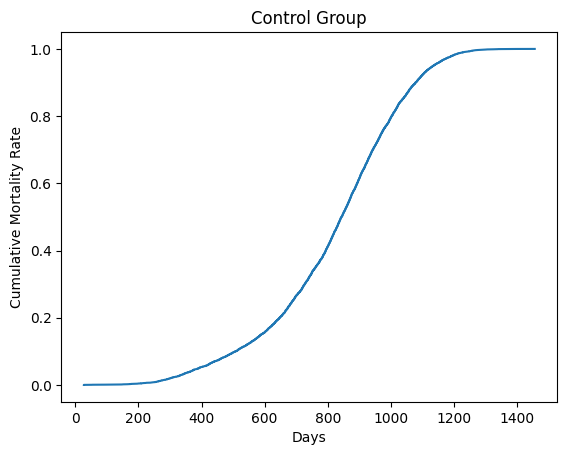

In [9]:
def graph_running_mortality_percentage(age_in_days: pd.DataFrame,
                                       running_mortality_percentage: pd.DataFrame,
                                       title: str) -> None: 
    plt.plot(age_in_days, running_mortality_percentage)
    plt.xlabel('Days')
    plt.ylabel('Cumulative Mortality Rate')
    plt.title(title)
    plt.show()

age_in_days = control_group.loc[:, AGE_IN_DAYS_COLUMN]
running_mortality_rate = control_group.loc[:, RUNNING_MORALITY_PERCENTAGE_COLUMN]

graph_running_mortality_percentage(age_in_days, running_mortality_rate, title='Control Group')

# Gompertz Model

We use a Gompertz curve to fit the data with the assumption it follows the Gompertz-Makeham Law of Mortality. Refer to the link below for more details:
https://en.wikipedia.org/wiki/Gompertz%E2%80%93Makeham_law_of_mortality

In [10]:
def gompertz(x, alpha, beta):
    return alpha * np.exp(beta * x)

@dataclass
class GompertzParameters:
    alpha: np.float64
    beta: np.float64

    @staticmethod
    def from_sequence(seq):
        return GompertzParameters(alpha=seq[0], beta=seq[1])

    def to_tuple(self) -> tuple[np.float64]:
        return (self.alpha, self.beta)

    def __str__(self) -> str:
        return f'(alpha={self.alpha:.4f}, beta={self.beta:.4f})'

    def __repr__(self) -> str:
        return f'(alpha={self.alpha:.4f}, beta={self.beta:.4f})'


def fit_gompertz_model(initial_parameters: GompertzParameters,
                       ages: pd.DataFrame,
                       mortality_rate: pd.DataFrame,
                       max_fit_iterations: int = 2_500) -> GompertzParameters:
    p0 = initial_parameters.to_tuple()
    predicted_parameters, covariance = curve_fit(gompertz, ages, mortality_rate, p0=p0, maxfev=max_fit_iterations)
    return GompertzParameters.from_sequence(predicted_parameters)

# Mortality Graphs

In [11]:
def population_at_daystart(data: pd.DataFrame) -> pd.DataFrame:
    total_population = calculate_total(data)
    population_at_start_of_day = (total_population) - data.cumsum()
    population_at_start_of_day = population_at_start_of_day.shift(1)
    population_at_start_of_day.loc[population_at_start_of_day.index.values[0]] = total_population
    return population_at_start_of_day.rename(columns={"dead": "Population"})

def calculate_mortality_rates(dead_counts: pd.DataFrame, population_data: pd.DataFrame) -> pd.DataFrame:
    return dead_counts['dead'] / population_data['Population']

def remove_days_without_deaths(data: pd.DataFrame) -> pd.DataFrame:
    return data[(data[["dead"]] != 0).all(axis=1)]

def graph_log_mortality_rate(experiment_group: pd.DataFrame, time_period_in_days: int):
    dead_counts = remove_days_without_deaths(group_ages(experiment_group, time_period_in_days))
    population_data = population_at_daystart(dead_counts)
    mortality_rate = calculate_mortality_rates(dead_counts, population_data)
    mortality_rate.apply(lambda x: np.log(x)).plot(style='.')
    plt.xlabel("Age")
    plt.ylabel("Mortality Rate")
    plt.title("Log Mortality Rate") 

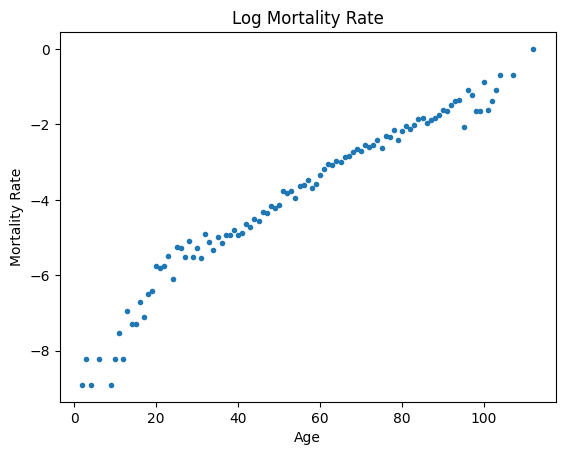

In [12]:
graph_log_mortality_rate(control_group, mouse_bin_period_in_days)

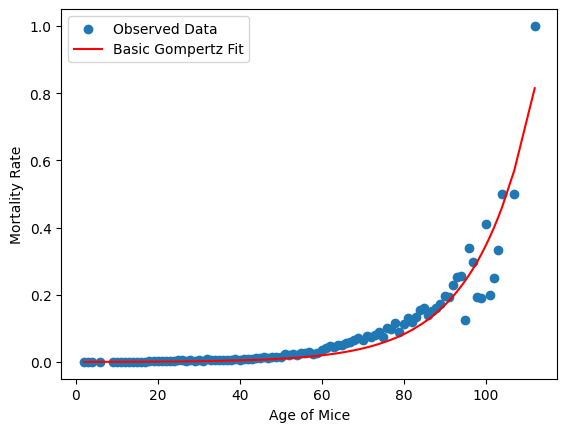

Fitted Parameters:
Alpha: 0.00026841766658910744
Beta: 0.00026841766658910744


In [13]:
@dataclass
class ExperimentSample:
    ages: pd.DataFrame
    mortality_rate: pd.DataFrame

def compute_experiment_sample(experiment_group: pd.DataFrame, bin_period_in_days: int):
    dead_counts = remove_days_without_deaths(group_ages(experiment_group, bin_period_in_days))
    population_data = population_at_daystart(dead_counts)

    ages = dead_counts.index
    mortality_rate = calculate_mortality_rates(dead_counts, population_data)

    return ExperimentSample(ages=ages, mortality_rate=mortality_rate)

def fit_gompertz_from_experiment(experiment_sample: ExperimentSample, intitial_parameters: GompertzParameters):
    ages = experiment_sample.ages
    mortality_rate = experiment_sample.mortality_rate
    
    predicted_parameters = fit_gompertz_model(initial_parameters, ages, mortality_rate)
    predicted_mortality = gompertz(ages, predicted_parameters.alpha, predicted_parameters.beta)
    
    return predicted_parameters, predicted_mortality
    
def plot_fitted_gompertz_curve(experiment_sample: ExperimentSample, predicted_mortality: pd.DataFrame):
    ages = experiment_sample.ages
    mortality_rate = experiment_sample.mortality_rate

    # Plot the results
    plt.scatter(ages, mortality_rate, label='Observed Data')
    plt.plot(ages, predicted_mortality, label='Basic Gompertz Fit', color='red')
    plt.xlabel('Age of Mice')
    plt.ylabel('Mortality Rate')
    plt.legend()
    plt.show()


initial_parameters = GompertzParameters(alpha=0.1, beta=0.085)

experiment_sample = compute_experiment_sample(control_group, mouse_bin_period_in_days)
parameters, predicted_mortality = fit_gompertz_from_experiment(experiment_sample, initial_parameters)
plot_fitted_gompertz_curve(experiment_sample, predicted_mortality)

print("Fitted Parameters:")
print("Alpha:", parameters.alpha)
print("Beta:", parameters.alpha)

In [14]:
mortality_rate = experiment_sample.mortality_rate
r_squared = r2_score(mortality_rate, predicted_mortality)
mse = mean_squared_error(mortality_rate, predicted_mortality)

print(f'R-squared: {r_squared}')
print(f'Mean Squared Error: {mse}')


R-squared: 0.9074622096224423
Mean Squared Error: 0.001818145324484942


# Human Data

Here we do some basic preprocessing to compute interesting statistics and also create the columns that are used in the mouse dataset. One small, but important fact worth mentioning is that the dataset is already binned by year which we multiply by 365 to get the number of days in which the data in binned. 

#### Potential Future Improvements
We are currently ignoring leap years as we expect them to have little effect on the outcome, however including them as a fact could be considered a future improvement.

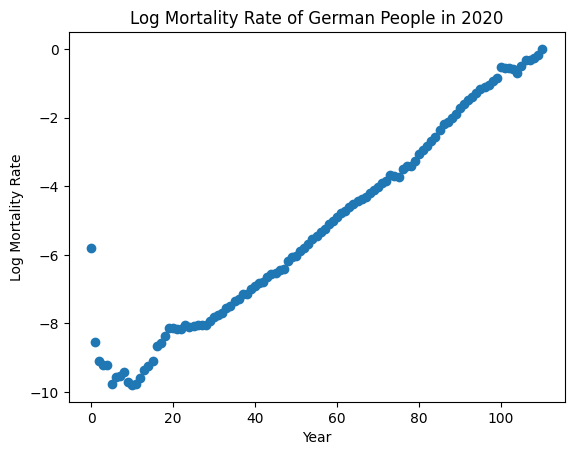

In [15]:
## Import  Human Data
human_mortality_df = pd.read_excel("./Lifespans_Humans.xlsx")
human_mortality_df

human_mortality_df['MortalityRate'] = human_mortality_df['Total'] / human_mortality_df['Population']
human_mortality_df['LogMortalityRate'] = human_mortality_df['MortalityRate'].apply(lambda x: np.log(x))

# Add columns expected by bootstrap methods
human_mortality_df[[AGE_IN_DAYS_COLUMN]] = human_mortality_df[[HUMAN_AGE_IN_YEARS_COLUMN]] * days_per_years
human_mortality_df[[DEATH_COLUMN]] = human_mortality_df[[HUMAN_DEATHS_PER_YEAR_COLUMN]]

plt.scatter(human_mortality_df['Age'], human_mortality_df['LogMortalityRate'])
plt.xlabel('Year')
plt.ylabel('Log Mortality Rate')
plt.title('Log Mortality Rate of German People in 2020')
plt.show()

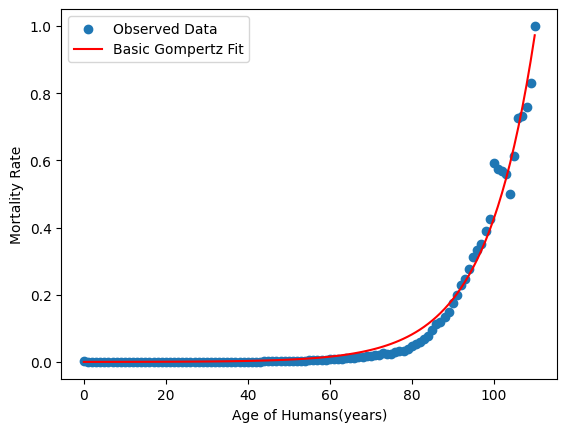

Fitted Parameters:
Alpha: 0.00011028263895295604
Beta: 0.08258451295469804


In [16]:
# Fit Human Data to Gompertz
ages = human_mortality_df['Age']
mortality_rates = human_mortality_df['MortalityRate']
human_samples = ExperimentSample(ages=ages, mortality_rate=mortality_rates)

human_initial_gompertz_parameters = GompertzParameters(alpha=0.1, beta=0.085)
predicted_parameters, predicted_mortality = fit_gompertz_from_experiment(human_samples, human_initial_gompertz_parameters)

predicted_mortality = gompertz(ages, predicted_parameters.alpha, predicted_parameters.beta)

# Plot the results
plt.scatter(ages, mortality_rates, label='Observed Data')
plt.plot(ages, predicted_mortality, label='Basic Gompertz Fit', color='red')
plt.xlabel('Age of Humans(years)')
plt.ylabel('Mortality Rate')
plt.legend()
plt.show()

print("Fitted Parameters:")
print("Alpha:", predicted_parameters.alpha)
print("Beta:", predicted_parameters.beta)


In [17]:
r_squared = r2_score(mortality_rates, predicted_mortality)
mse = mean_squared_error(mortality_rates, predicted_mortality)

print(f'R-squared: {r_squared}')
print(f'Mean Squared Error: {mse}')


R-squared: 0.982527129380706
Mean Squared Error: 0.0007951298970120608


In [18]:
@dataclass
class BootstrapSetup:
    dataset: pd.DataFrame
    dataset_bin_period: int
    initial_parameters: GompertzParameters
    sample_percentage: float

def create_bootstrap_sample(df: pd.DataFrame, sample_percentage: int) -> pd.DataFrame:
    n_samples = int(len(df) * sample_percentage)
    indices = np.random.randint(low=0, high=len(df), size=n_samples)
    return df.iloc[indices]

def bootstrap_gompertz_parameters_once(setup: BootstrapSetup) -> GompertzParameters:
    bootstrap_sample = create_bootstrap_sample(setup.dataset, setup.sample_percentage)
    bootstrap_experiment_sample = compute_experiment_sample(bootstrap_sample, setup.dataset_bin_period)
    parameters, _ = fit_gompertz_from_experiment(bootstrap_experiment_sample, setup.initial_parameters)
    return parameters

def bootstrap_gompertz_parameters(setup: BootstrapSetup, n_trials: int):
    parameters_list = []
    for _ in range(n_trials):
        parameters = bootstrap_gompertz_parameters_once(setup)
        parameters_list.append(parameters)
    return parameters_list

def calculate_parameter_statistics(gompertz_parameters: [GompertzParameters]) -> GompertzParameters:
    alphas = np.array([p.alpha for p in gompertz_parameters])
    betas = np.array([p.beta for p in gompertz_parameters])
    
    parameter_mean = GompertzParameters(alpha=alphas.mean(), beta=betas.mean())
    parameter_variance = GompertzParameters(alpha=alphas.var(), beta=betas.var())
    
    return parameter_mean, parameter_variance

# Measuring Parameter Variance
Here we select randomly with replacement (bootstrap) death occurrances from each dataset and then predict a gompertz curve for each sample subset. This is followed with measuring the mean and the variance of the fitted parameters of the Gompertz curve. The latter statistic is especially useful in measuring in rough terms how "Gompertz-like" the data is. In other words, with a large variance this implies that model is not robust or generalize well therefore the data is not gompertz like. On the other hand, if it has low variance this means that the Gompertz curve is likely a model for fitting the data.

In [19]:
sample_percentage = 0.1

In [20]:
initial_parameters = GompertzParameters(alpha=0.1, beta=0.085)
n_trials_mice = int(sqrt(len(control_group)))

n_samples = int(len(control_group) * sample_percentage)
mouse_bootstrap_setup = BootstrapSetup(control_group, dataset_bin_period=30, initial_parameters=initial_parameters,
                                       sample_percentage=sample_percentage)

mouse_bootstrapped_parameters = bootstrap_gompertz_parameters(mouse_bootstrap_setup, n_trials=n_trials_mice)
mouse_parameter_mean, mouse_parameter_variance = calculate_parameter_statistics(mouse_bootstrapped_parameters)

print(f'Mouse Parameter Statistics:')
print(f'mu = {mouse_parameter_mean}')
print(f's^2 =  {mouse_parameter_variance}')

Mouse Parameter Statistics:
mu = (alpha=0.0025, beta=0.1366)
s^2 =  (alpha=0.0000, beta=0.0004)


In [21]:
n_trials_humans = int(sqrt(len(human_mortality_df)))

# we set dataset_bin_period to 365 because the data has already been binned by the number of days in a years (365).
# Note: this ignore leap years, as it is assumed to be insigificant, but can be considered as a potential improvment.
human_bootstrap_setup = BootstrapSetup(human_mortality_df, dataset_bin_period=365, initial_parameters=initial_parameters, 
                                       sample_percentage=sample_percentage)

human_bootstrapped_parameters = bootstrap_gompertz_parameters(human_bootstrap_setup, n_trials=n_trials_humans)
human_parameter_mean, human_parameter_variance = calculate_parameter_statistics(human_bootstrapped_parameters)

print(f'Human Parameter Statistics:')
print(f'mu = {human_parameter_mean}')
print(f's^2 =  {human_parameter_variance}')

Human Parameter Statistics:
mu = (alpha=0.0221, beta=0.0468)
s^2 =  (alpha=0.0003, beta=0.0006)
